In [1]:
%matplotlib inline

from shared_content import *

In [2]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = False
figdir = 'MCS_JINST/Figures/'

In [3]:
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 

First the range-based bias and resolution figures from MCBNBMCTrack

In [4]:
filedir = 'anafiles/'
#'SingleMuonRecoTrack'
#'MCBNBSelectedRecoTrack'
#'DataBNBSelectedRecoTrack'
#'MCBNBRecoTrack'
#'SingleMuonMCTrack'
anatype = 'MCBNBMCTrack' 

seglen = 14
myres = 3
if 'MCTrack' in anatype: myres = 0
myfile = 'MCSBiasStudy_%s_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstantMOMENTUMDEPENDENT.root'%( anatype, myres )


In [5]:
df, segdf = get_dfs(filedir + myfile)

In [14]:
#reco-true/true
def fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False, myaddtext = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            titlestring = '$%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[slicevar],binmin,binmax)
            t =plt.title(titlestring,fontsize=20)
            #move the title up a bit
            #t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gauss Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                addtext = 'Raw: \nstd = %0.2f, \nmean = %0.2f'%(mystd,mymean)
                plt.text(plt.xlim()[0] + (plt.xlim()[1]-plt.xlim()[0])*0.05, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            plt.xlabel('$(%s - %s)(%s)^{-1}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=20)
            plt.ylabel('Counts',fontsize=20)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
     
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT    
    plt.figure(figsize=(10,6))
    #horizontal thick line at bias = 0
    blah = plt.axhline(y=0,xmin=plt.xlim()[0], xmax=plt.xlim()[1],color='black',linewidth=2,linestyle='dashed')
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label='Mean of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{N}$')
    plt.ylabel('Fractional Bias',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=15)
    t = plt.title('Range-Based Fractional Bias',fontsize=20)
    #t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
        
       
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)
        
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label='Width of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{2N}$')
    plt.ylabel('Fractional Resolution',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    t = plt.title('Range-Based Momentum Resolution',fontsize=20)
    plt.legend(loc='best',fontsize=15)
    #move the title up a bit
    #t.set_y(1.05) 
                    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
        
        
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)
    
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)
        
    

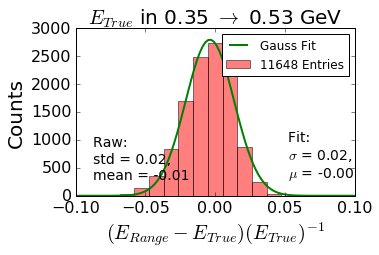

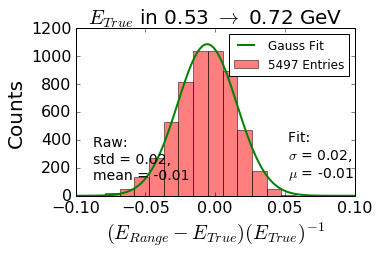

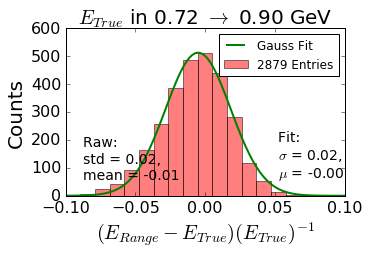

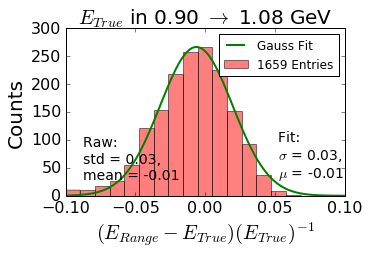

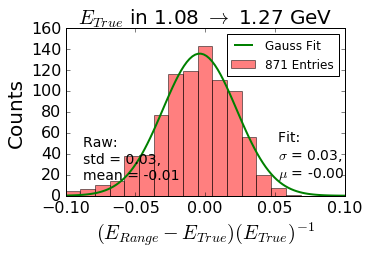

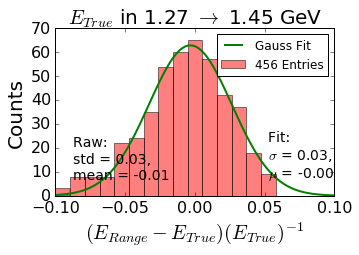

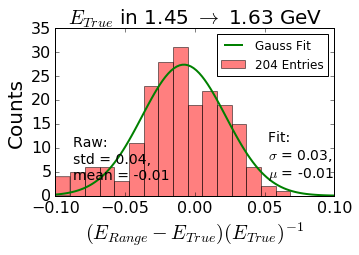

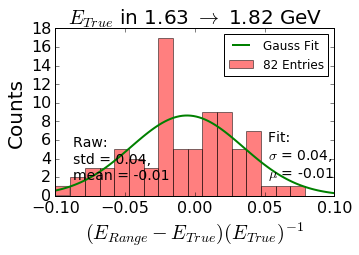

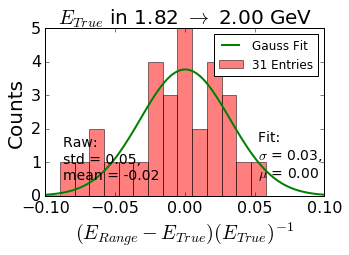

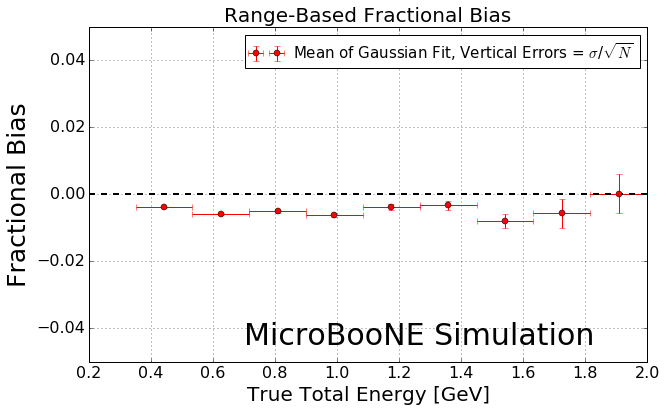

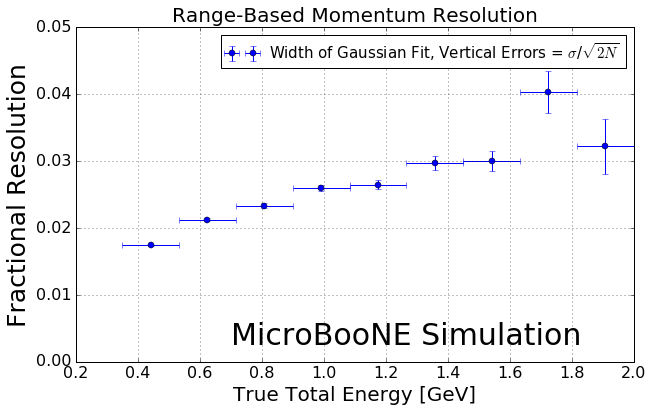

In [15]:
# Fractional bias plot for True vs Range energy for single MCTrack section only
if anatype == 'MCBNBMCTrack':

    fractional_bias_resolution_plot(xvar='true_E',yvar='full_range_energy',xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'true_E',
                       slicetitlebase = 'true_range_resolution_%s'%anatype,
                       slicebins = np.linspace(-0.1,0.1,20),
                       biasplotname = 'true_range_bias_%s.png'%anatype,
                       resplotname = 'true_range_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.05,.05),
                       resmainfig_ylims = (0,.05),
                       usegausfit = True,
                       myaddtext = 'MicroBooNE Simulation')

Now we have the basic comparison fig for the good scan sample in data

In [16]:
anatype = 'DataBNBSelectedRecoTrack' 

myres = 3
if 'MCTrack' in anatype: myres = 0
myfile = 'MCSBiasStudy_%s_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstantMOMENTUMDEPENDENT.root'%( anatype, myres )


df, segdf = get_dfs(filedir + myfile)

#Read in handscan info if working with data
if anatype == 'DataBNBSelectedRecoTrack':
    filedir = 'handscan_results/'
    myfile = 'handscan_results_kaleko.csv'
    
    hsdf = pd.read_csv(filedir + myfile,index_col=False)
       
    #Column names with spaces are hard to deal with, this is easy
    cols = hsdf.columns
    cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
    hsdf.columns = cols
    
    #If no optional comments were typed in it shows up as NaN
    #Let's just make a column of "optional comments present" (boolean)
    
    hsdf['comments_present'] = hsdf['optional_comments'].notnull()
    
    #Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
    hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0
    
    #maybe bad is either definitely_bad, or if comments are present (more conservative)
    hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']
    
    print "total length of hsdf is",len(hsdf)
    print "number of definitely bad is",len(hsdf.query('definitely_bad'))
    print "number of maybe bad is",len(hsdf.query('maybe_bad'))
    
    #let's rename run, subrun, eventid columns to match the MCS df
    #for now just make a new column because it's easier
    hsdf['run'] = hsdf['Run']
    hsdf['subrun'] = hsdf['Subrun']
    hsdf['eventid'] = hsdf['Event_ID']
    
    df = df.merge(hsdf, on=['run','subrun','eventid'])

    segdf = segdf.merge(hsdf, on=['run','subrun','eventid'])

total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [17]:
len(df.query('not maybe_bad and full_length > 200.'))

142

In [18]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None, nbins=50):
    plt.figure(figsize=(10,6)) 
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = df.query(myquery)[xvar].values
    myy = df.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,nbins),np.linspace(0,2,nbins))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=20)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=20)
    blha = plt.title('Selected, Well Reconstructed Tracks from $\\nu_\\mu$CC Data',fontsize=18)
    blha.set_y(1.04)
    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.375, plt.ylim()[1]*0.1, addtext, fontsize=30)
        
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname,dpi=600)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"

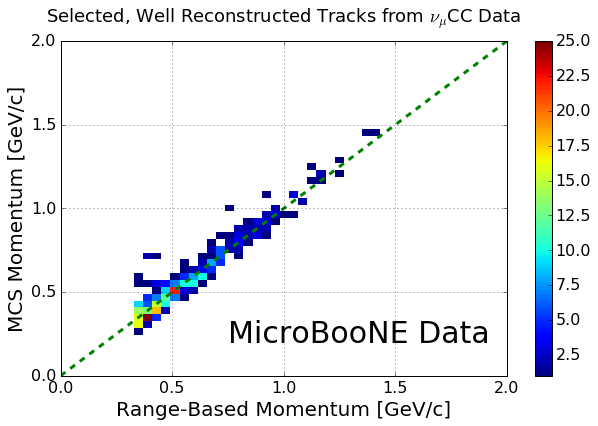

In [19]:
#Breakdown of events that were handscanned as good, and those handscanned as bad
if anatype == 'DataBNBSelectedRecoTrack':

    extraquery = 'not maybe_bad'
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_range_momentum_DataRecoTracks_goodhandscan.png',
                            extraquery = extraquery,
                        addtext = 'MicroBooNE Data')

Now the highland validation plot for the data handscanned sample

In [20]:
def deflection_plot(binmin,binmax,nbins,extraquery=None,plotname=None, addtext=None, figname = None, customtitle = None):
    
    fig = plt.figure(figsize=(10,6))
    
    poop = plt.grid(True)
    
    myquery = 'run < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    print myquery
    mybins = np.linspace(binmin,binmax,nbins)
    
#     myvar1 = 'dthetayoverpredictedRMS_fromMCS'
#     myvar2 = 'dthetaxoverpredictedRMS_fromMCS'
    myvar1 = 'dthetayoverpredictedRMS_fromMCS_with3res'
    myvar2 = 'dthetaxoverpredictedRMS_fromMCS_with3res'
    
    myvals = np.append(
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar1,binmin,myvar1,binmax))[myvar1].values,
        segdf.query(myquery).\
        query('%s > %f and %s < %f'%(myvar2,binmin,myvar2,binmax))[myvar2].values
    )
        
    mystd = np.std(myvals)
    mymean = np.mean(myvals)
    print "HISTOGRAM HAS %d ENTRIES"%len(myvals)
    datahist = plt.hist(myvals,bins=mybins,normed=True,
                             alpha=0.5,label='$\Delta\\theta/\\sigma_o^{RMS}$ Values')#,
                            #weights = myweights)
   
    datahist_nonorm = np.histogram(myvals,bins=mybins,normed=False)
    
    binvals = datahist[0]
    bincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
    # Fit a normal distribution
    gmod = Model(gaussian)
    #initial random guesses of 1, 1, 2
    result = gmod.fit(binvals, x=bincenters, amp=1, cen=1, wid=2)

    #print(result.fit_report())
    #print help(result)
    #plt.plot(bincenters, binvals,         'bo')
    #plt.plot(bincenters, result.init_fit, 'k--')
    print result.params
    plt.plot(bincenters, result.best_fit, 'g-',\
             label='Gaussian Fit: $\sigma$ = %0.3f, $\mu$ = %0.3f' % (result.params['wid'],result.params['cen']),\
            linewidth=4)
  
    #data_mu, data_std = norm.fit(myvals)
    
    #myhighland = highlandE(data_std)

    # Plot the PDF.
    #x = np.linspace(binmin,binmax,100)
    #p = norm.pdf(x, data_mu, data_std)
    #plt.plot(x, p, 'g', linewidth=4,label='Gaussian Fit to Data')
    
    
    plt.title('%s'%titles[anatype],fontsize=20)
   
    if customtitle is not None:
        plt.title(r'%s'%customtitle,fontsize=20)
        
    plt.xlabel('$\Delta\\theta_j$ / $\sigma_{(o,j)}^{RMS}$',fontsize=30)
    blah = plt.legend(loc='best')
    leg = plt.legend(loc=2,fontsize=16)

    blah = plt.ylim((0,0.65))
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.10, plt.ylim()[1]*0.82, addtext, fontsize=25)
        
    if write_figures:
        fullfigname = figdir + 'Highland_validation_%s.png' % anatype
        if figname is not None:
            fullfigname = figdir + figname
            
        print "\n\n WRITING FIGURE %s! \n\n"%fullfigname
        plt.tight_layout()
        if plotname is not None: plt.savefig(figdir + plotname,dpi=600)
        else: plt.savefig(fullfigname,dpi=600)

In [21]:
# #Quick study to verify the number of entries in that histogram makes sense
# myvals = []
# for x in xrange(600):
#     thissegcount = len(segdf.query('run < 999999 and not maybe_bad and counter == %d'%x))
#     if not thissegcount: continue
#     myvals.append(thissegcount)
    
# blah = plt.hist(myvals,bins = np.linspace(0,40,42))
# print "The mean number of segments per track is %0.2f" % np.mean(myvals)

# first = 'run < 9999999 and not maybe_bad and dthetayoverpredictedRMS_fromMCS > -5 and dthetayoverpredictedRMS_fromMCS < 5'
# second = 'run < 9999999 and not maybe_bad and dthetaxoverpredictedRMS_fromMCS > -5 and dthetaxoverpredictedRMS_fromMCS < 5'
# print "The actual number of entries in the Highland histogram is %d."%(len(segdf.query(first)) + len(segdf.query(second)))
# print "Mean number of segments * 396 tracks * 2 scatters per track should equal the above number."
# print "Any difference comes from scatters that are outside the -5 to 5 sigma bin limits."

run < 99999999 and not maybe_bad
HISTOGRAM HAS 9197 ENTRIES
Parameters([('amp', <Parameter 'amp', value=0.97700570109015583 +/- 0.0154, bounds=[-inf:inf]>), ('cen', <Parameter 'cen', value=-0.009241540780049011 +/- 0.0181, bounds=[-inf:inf]>), ('wid', <Parameter 'wid', value=0.99356578890499503 +/- 0.0181, bounds=[-inf:inf]>)])


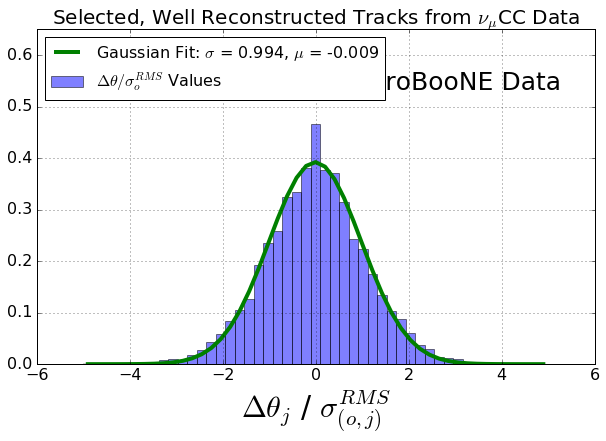

In [22]:
if anatype == 'DataBNBSelectedRecoTrack':
    myextraquery = 'not maybe_bad'
    dummy = deflection_plot(-5,5,50,extraquery=myextraquery,\
                            customtitle='Selected, Well Reconstructed Tracks from $\\nu_\\mu$CC Data',\
                            figname = 'Highland_validation_DataBNBSelectedRecoTrack_goodscan.png',
                           addtext = 'MicroBooNE Data')
    
    

Now the fractional bias/resolution overlay plots for simulation and data

In [23]:
anatypes = ['MCBNBSelectedRecoTrack','DataBNBSelectedRecoTrack']
filedir = 'anafiles/'

df_dict = {}

for anatype in anatypes:
    
    myres = 3
    if 'MCTrack' in anatype: myres = 0
    myfile = 'MCSBiasStudy_%s_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstantMOMENTUMDEPENDENT.root'%( anatype, myres )

    df_dict[anatype], dummy = get_dfs(filedir+myfile)
    
#Read in handscan info if working with data
filedir = 'handscan_results/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

df_dict['DataBNBSelectedRecoTrack'] = df_dict['DataBNBSelectedRecoTrack']\
                                        .merge(hsdf, on=['run','subrun','eventid'])


total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [24]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False, addtext = None):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',markersize=10,label='%s'%titles[anatype])
    plt.ylabel('Fractional Bias',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Bias for Various Input Samples',fontsize=20)
    blah = plt.axhline(y=0,xmin=-99999, xmax=999999,color='black',linewidth=2,linestyle='dashed')
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if addtext is not None:
        plt.text(plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.1, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, addtext, fontsize=30)
        
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)

In [25]:
def res_eqtn(x,a,b,c):
    return a/np.sqrt(x-b) + c

def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False,addtext = None,
                              draw_fit = False):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            print myquery
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if anatype == 'MCBNBSelectedRecoTrack':
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',markersize=10,label='%s'%titles[anatype])
            
        #kaleko adding draw fit portion for simulation only
        if draw_fit and anatype == 'MCBNBSelectedRecoTrack':
            popt, pcov = curve_fit(res_eqtn, bincenters[:-1], mystds, sigma=myerrs_res)
            fitx = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
            fity = res_eqtn(fitx,popt[0],popt[1],popt[2])
            labelstring = 'Resolution Fit to Simulation: ' 
            labelstring += '$[\\frac{a}{\sqrt{L-b}} + c]$'
            plt.plot(fitx,fity,'r-',label=labelstring)
        #kaleko end adding draw fit portion
        
    plt.ylabel('Fractional Resolution',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Momentum Resolution for Various Input Samples',fontsize=20)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if addtext is not None:
        plt.text(plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.1, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, addtext, fontsize=30)
        
        
            
    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)

full_range_momentum > 0.350000 and full_range_momentum < 0.533333
full_range_momentum > 0.533333 and full_range_momentum < 0.716667
full_range_momentum > 0.716667 and full_range_momentum < 0.900000
full_range_momentum > 0.900000 and full_range_momentum < 1.083333
full_range_momentum > 1.083333 and full_range_momentum < 1.266667
full_range_momentum > 0.350000 and full_range_momentum < 0.533333
full_range_momentum > 0.533333 and full_range_momentum < 0.716667
full_range_momentum > 0.716667 and full_range_momentum < 0.900000
full_range_momentum > 0.900000 and full_range_momentum < 1.083333
full_range_momentum > 1.083333 and full_range_momentum < 1.266667


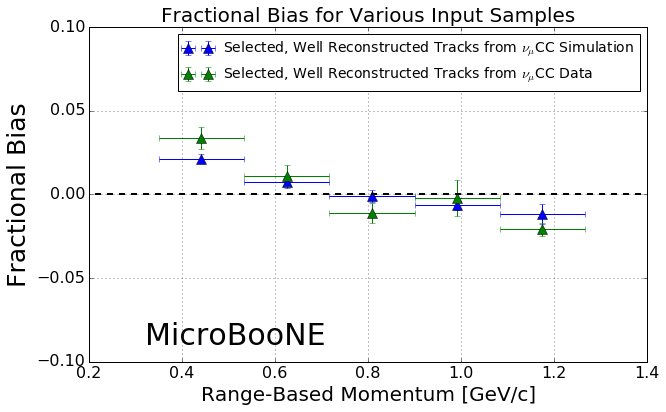

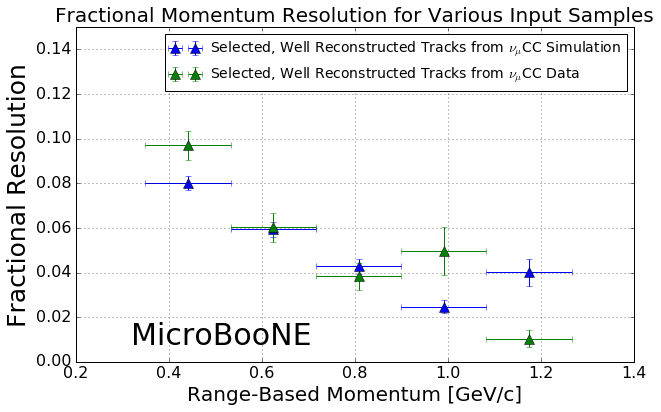

In [26]:
fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_multiplesamples_publicplot.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True,addtext = 'MicroBooNE')

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_multiplesamples_publicplot.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True,addtext = 'MicroBooNE')

In [27]:
df_dict[anatype].columns.values

array(['full_length', 'full_integrated_length', 'full_range_energy',
       'full_range_momentum', 'full_integrated_range_energy',
       'full_integrated_range_momentum', 'full_MCS_energy',
       'full_MCS_momentum', 'true_E', 'true_momentum', 'theta',
       'angle_wrt_x', 'angle_wrt_y', 'run', 'subrun', 'eventid',
       'full_MCS_momentum_inverse', 'full_range_momentum_inverse',
       'true_momentum_inverse', 'MCT_PDG', 'MCT_origin', 'EVD_Index',
       'Event_ID', 'Run', 'Subrun', 'Track_Start_z-_coordinate',
       '1_good_0_bad', 'optional_comments', 'comments_present',
       'definitely_bad', 'maybe_bad'], dtype=object)

In [28]:
print anatype

DataBNBSelectedRecoTrack


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118c01590>]], dtype=object)

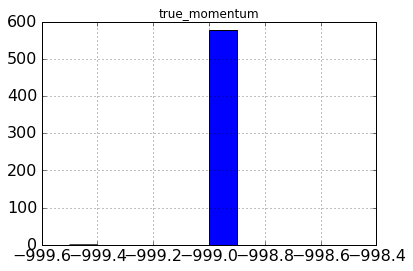

In [29]:
df_dict[anatype].hist('true_momentum')

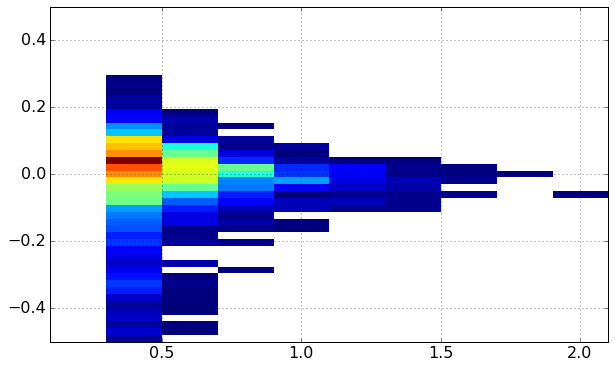

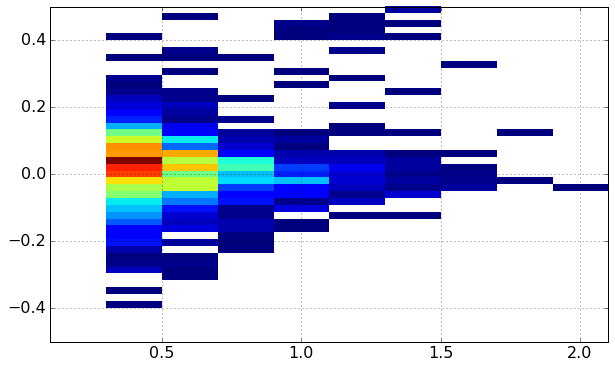

In [30]:
#Test some stuff for giuseppe (sign of bias flipped for him)
anatype = 'MCBNBSelectedRecoTrack'
#range
myquery = 'full_range_momentum > 0 and full_range_momentum < 2'
mydf = df_dict[anatype].query(myquery)
pmcsinv = mydf['full_MCS_momentum_inverse'].values
praninv = mydf['full_range_momentum_inverse'].values
pran = mydf['full_range_momentum'].values
plt.figure(figsize=(10,6))
blah = plt.hist2d(y=(pmcsinv-praninv)/praninv,x=pran,cmin=1,bins=(np.linspace(0.1,2.1,11),np.linspace(-0.5,0.5,50)))
blah = plt.grid(True)

#true momentum
myquery = 'true_momentum > 0 and true_momentum < 2'
mydf = df_dict[anatype].query(myquery)
pmcsinv = mydf['full_MCS_momentum_inverse'].values
praninv = mydf['true_momentum_inverse'].values
pran = mydf['true_momentum'].values
plt.figure(figsize=(10,6))
blah = plt.hist2d(y=(pmcsinv-praninv)/praninv,x=pran,cmin=1,bins=(np.linspace(0.1,2.1,11),np.linspace(-0.5,0.5,50)))
blah = plt.grid(True)

In [31]:
#reco-true/true
def giuseppe_fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False, myaddtext = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            titlestring = '$%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
            (latextitles[slicevar],binmin,binmax)
            t =plt.title(titlestring,fontsize=20)
            #move the title up a bit
            #t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gauss Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            plt.xlabel('$(%s - %s)(%s)^{-1}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=20)
            plt.ylabel('Counts',fontsize=20)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1)
     
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT    
    plt.figure(figsize=(10,6))
    #horizontal thick line at bias = 0
    blah = plt.axhline(y=0,xmin=plt.xlim()[0], xmax=plt.xlim()[1],color='black',linewidth=2,linestyle='dashed')
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label='Mean of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{N}$')
    plt.ylabel('Fractional Bias',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=15)
    t = plt.title('Range-Based Fractional Bias',fontsize=20)
    #t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
        
       
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)
        
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label='Width of Gaussian Fit, Vertical Errors = $\sigma$/$\sqrt{2N}$')
    plt.ylabel('Fractional Resolution',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    t = plt.title('Range-Based Momentum Resolution',fontsize=20)
    plt.legend(loc='best',fontsize=15)
    #move the title up a bit
    #t.set_y(1.05) 
                    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
        
        
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)
    
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)
        
    

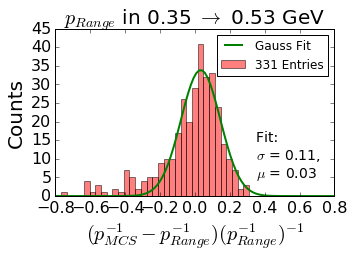

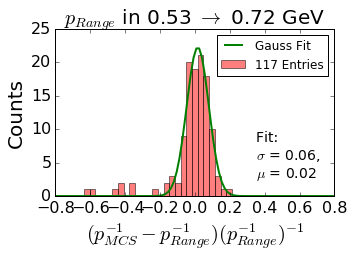

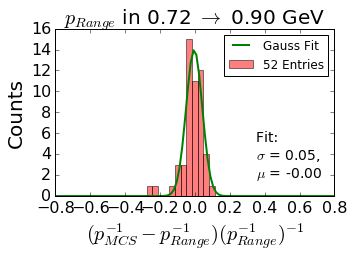

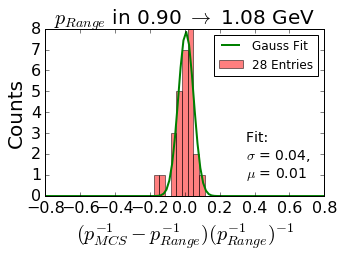

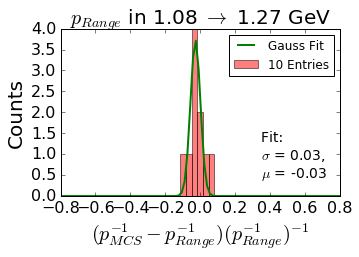

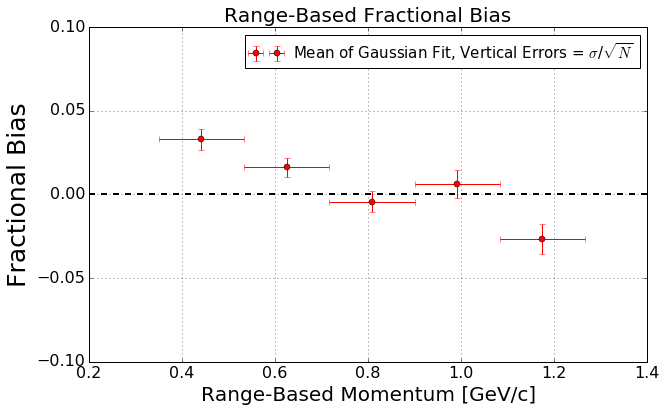

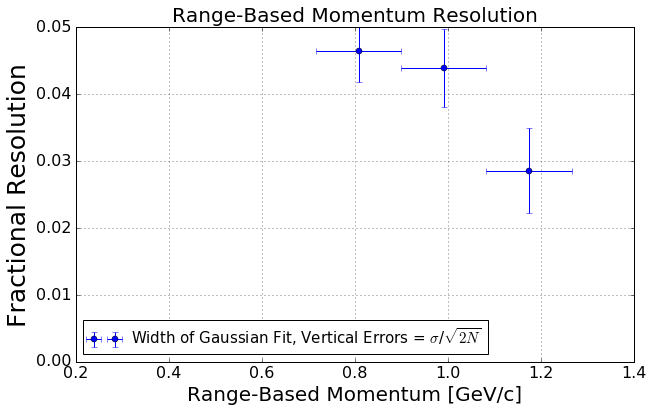

In [32]:
# fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
#                      xbins=np.linspace(0.35,1.26666667,6),
#                        plot_bin_distributions = True,
#                        slicevar = 'full_range_momentum',
#                        slicetitlebase = None,
#                        slicebins = np.linspace(-0.8,0.8,50),
#                        biasplotname = 'MCS_range_bias_multiplesamples_publicplot.png',
#                        biasmainfig_ylims = (-.10,.10),
#                         usegausfit = True,addtext = 'MicroBooNE')

giuseppe_fractional_bias_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                                         xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = 'NOTHING_%s'%anatype,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'NOTHING_bias_%s.png'%anatype,
                       resplotname = 'NOTHING_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                       resmainfig_ylims = (0,.05),
                       usegausfit = True,
                       myaddtext = None)

full_length > 100.000000 and full_length < 155.555556
full_length > 155.555556 and full_length < 211.111111
full_length > 211.111111 and full_length < 266.666667
full_length > 266.666667 and full_length < 322.222222
full_length > 322.222222 and full_length < 377.777778
full_length > 377.777778 and full_length < 433.333333
full_length > 433.333333 and full_length < 488.888889
full_length > 488.888889 and full_length < 544.444444
full_length > 544.444444 and full_length < 600.000000
full_length > 100.000000 and full_length < 155.555556
full_length > 155.555556 and full_length < 211.111111
full_length > 211.111111 and full_length < 266.666667
full_length > 266.666667 and full_length < 322.222222
full_length > 322.222222 and full_length < 377.777778
full_length > 377.777778 and full_length < 433.333333
full_length > 433.333333 and full_length < 488.888889
full_length > 488.888889 and full_length < 544.444444
full_length > 544.444444 and full_length < 600.000000


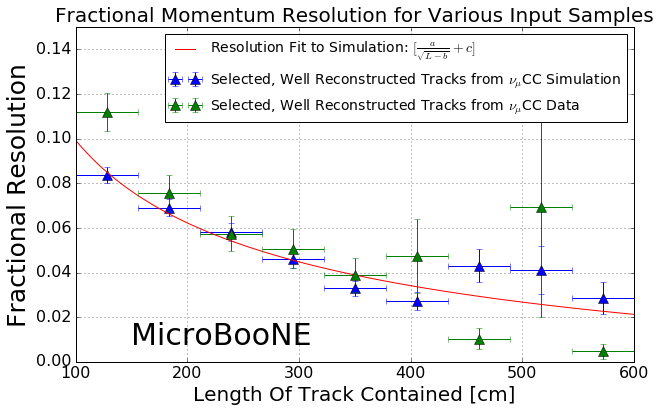

In [33]:
#tim bolton request fitting 1/sqrt(L), so i do that here
fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(100,600,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_length',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = None,
                       resmainfig_ylims = (0,.15),
                        usegausfit = True,addtext = 'MicroBooNE',
                          draw_fit=True)

Now the fractional bias/resolution overlay plots for simulation with fixed highland formula, and simulation with nominal highland formula

In [34]:
anatypes = ['MCBNBSelectedRecoTrack','MCBNBSelectedRecoTrackNominalHL']
filedir = 'anafiles/'

df_dict = {}

for anatype in anatypes:
    
    myres = 3
    myfile = 'MCSBiasStudy_%s_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstantMOMENTUMDEPENDENT.root'%( anatype, myres )
    if 'Nominal' in anatype:
        myfile = 'MCSBiasStudy_MCBNBSelectedRecoTrack_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstant13.6.root'%\
        ( myres )
   
    
    df_dict[anatype], dummy = get_dfs(filedir+myfile)
    

In [35]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False,addtext=None):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if 'MCBNBSelectedRecoTrack' in anatype:
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        mylabel = 'Simulated Muons with Tuned Highland Formula'
        mycolor = 'b'
        if 'Nominal' in anatype:
            mylabel = 'Simulated Muons with Nominal Highland Formula'
            mycolor = 'r'
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',color=mycolor,markersize=10,label=mylabel)
    plt.ylabel('Fractional Bias',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Bias for Various Input Samples',fontsize=20)
    blah = plt.axhline(y=0,xmin=-9999999, xmax=999999,color='black',linewidth=2,linestyle='dashed')
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if addtext is not None:
        plt.text(plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.1, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, addtext, fontsize=30)

    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname,dpi=600)

In [36]:
#reco-true/true
def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False,addtext=None):
    
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for anatype in anatypes:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if 'MCBNBSelectedRecoTrack' in anatype:
                myquery += ' and (MCT_PDG == 13 or MCT_PDG == -13)'
                
            mydf = df_dict[anatype].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:

                datahist = np.histogram((reco-true)/true,bins=slicebins)

                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])

                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
        
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT   
        mylabel = 'Simulated Muons with Tuned Highland Formula'
        mycolor = 'b'
        if 'Nominal' in anatype:
            mylabel = 'Simulated Muons with Nominal Highland Formula'
            mycolor = 'r'
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,xerr=binwidth/2,fmt='^',color=mycolor,markersize=10,label=mylabel)
        
    plt.ylabel('Fractional Resolution',fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=14)
    t = plt.title('Fractional Momentum Resolution for Various Input Samples',fontsize=20)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if addtext is not None:
        plt.text(plt.xlim()[0]+(plt.xlim()[1]-plt.xlim()[0])*0.1, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, addtext, fontsize=30)

    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname,dpi=600)

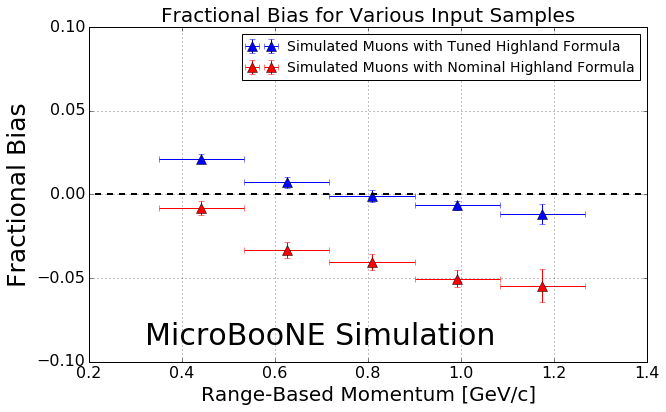

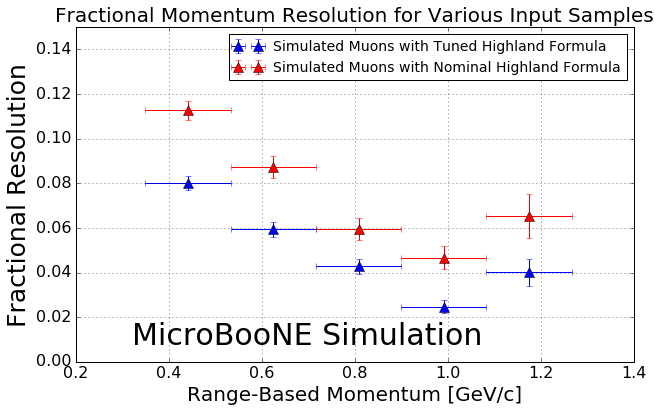

In [37]:
fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'MCS_range_bias_compareHighlandTuning_publicplot.png',
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True,addtext='MicroBooNE Simulation')

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,1.26666667,6),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'MCS_range_resolution_compareHighlandTuning_publicplot.png',
                       resmainfig_ylims = (0,.15),
                        usegausfit = True,addtext='MicroBooNE Simulation')

Now the figure where I tune the Highland formula...

 

 Writing the Highland retuning figure!! MCS_JINST/Figures/highland_constant_optimization_momentumdependent.png




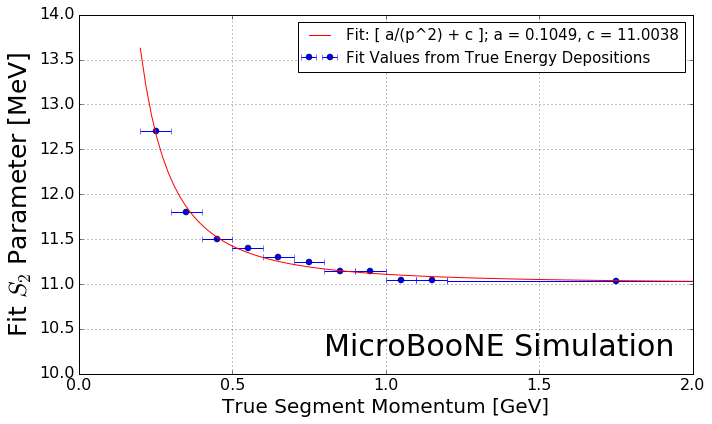

In [38]:
myx = [.25,.35,.45,.55,.65,.75,.85,.95,1.05,1.15,1.75]
lower_xerr = [ .05 ] * len(myx)
upper_xerr = [ .05 ] * len(myx)
lower_xerr[-1] = 1.75-1.15 - upper_xerr[-1]
upper_xerr[-1] = lower_xerr[-1]
asymmetric_error = [lower_xerr,upper_xerr]

# ax1.errorbar(x, y, xerr=asymmetric_error, fmt='o')
myc = [12.7,11.8,11.5,11.4,11.3,11.25,11.15,11.15,11.05,11.05,11.03]
plt.figure(figsize=(10,6))
plt.errorbar(myx,myc,xerr=asymmetric_error,fmt='bo',label='Fit Values from True Energy Depositions')
#plt.title("Highland Constant: 14cm Segments, Momentum Dependence",fontsize=16)
plt.xlabel('True Segment Momentum [GeV]',fontsize=20)
plt.ylabel('Fit $S_2$ Parameter [MeV]',fontsize=25)
plt.ylim((10,14))
plt.xlim((0,2))
plt.grid(True)

from scipy.optimize import curve_fit
def func(x,a,c):
    return (a/(x*x)) + c
#popt, pcov = curve_fit(func,myx,myc)

curvex = np.linspace(0.2,2,100)
a = 0.1049
c = 11.0038
curvey = func(curvex,a,c)
plt.plot(curvex,curvey,'r',label='Fit: [ a/(p^2) + c ]; a = %0.4f, c = %0.4f'%(a,c))
plt.legend(fontsize=15)


myaddtext = 'MicroBooNE Simulation'
plt.text(plt.xlim()[1]*0.4, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)

if write_figures is not None:
    plotname = 'highland_constant_optimization_momentumdependent.png'
    print " \n\n Writing the Highland retuning figure!! %s\n\n" % (figdir+plotname)
    plt.tight_layout()
    plt.savefig(figdir + plotname,dpi=600)

 

 Writing the Highland depiction!! MCS_JINST/Figures/highland_formula_visualized_twoforms.png




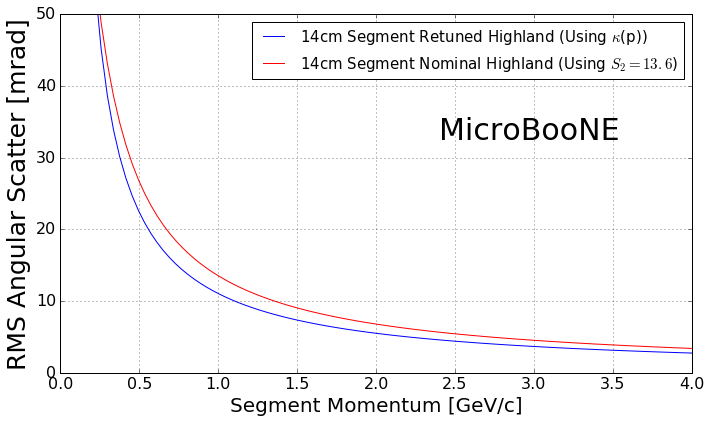

In [39]:
def beta(true_p_GEV):
    return np.sqrt( 1 - ((0.106*0.106)/(true_p_GEV * true_p_GEV + 0.106*0.106)) )

def func(x,a,c):
    return (a/(x*x)) + c

def highland_modified(p):
    a = 0.1049
    c = 11.0038
    return func(p,a,c)/p*beta(p)

def highland_normal(p):
    return 13.6 / p*beta(p)


myps = np.linspace(0.1,4,100)
myhl = highland_modified(myps)
myhl_normal = highland_normal(myps)

plt.figure(figsize=(10,6))
plt.plot(myps,myhl,'b',label='14cm Segment Retuned Highland (Using $\kappa$(p))')
plt.plot(myps,myhl_normal,'r',label='14cm Segment Nominal Highland (Using $S_2=13.6$)')
plt.legend(fontsize=15)
plt.grid(True)
plt.ylim((0,50))
plt.xlabel('Segment Momentum [GeV/c]',fontsize=20)
plt.ylabel('RMS Angular Scatter [mrad]',fontsize=25)
#plt.title('Highland Formula Visualized in Two Forms',fontsize=16)


myaddtext = 'MicroBooNE'
plt.text(plt.xlim()[1]*0.6, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.65, myaddtext, fontsize=30)


if write_figures is not None:
    plotname = 'highland_formula_visualized_twoforms.png'
    print " \n\n Writing the Highland depiction!! %s\n\n" % (figdir+plotname)
    plt.tight_layout()
    plt.savefig(figdir + plotname,dpi=600)

Now the bias/resolution plots for exiting reconstructed tracks

In [40]:
filedir = 'anafiles/'
anatype = 'MCBNBRecoTrackExiting'
myres = 3
if 'MCTrack' in anatype: myres = 0
myfile = 'MCSBiasStudy_%s_anaout_14cmseg_%dres_bothscatters_nonrelfix_realdedx1_highlandconstantMOMENTUMDEPENDENT.root'%( anatype, myres )
df, segdf = get_dfs(filedir + myfile)

In [61]:
def fractional_bias_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False,
                                   myaddtext = None, myresylabel = None,mybiasylabel = None,
                                   myrestitle = None, mybiastitle = None):

    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)
    myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []

    for x in xrange(len(binning)-1):
        
        binmin = binning[x]
        binmax = binning[x+1]
        #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
        myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
        if anatype == 'DataBNBSelectedRecoTrack': 
            myquery += ' and not maybe_bad'
        if extraquery is not None:
            myquery += ' and %s' % extraquery
            
        mydf = df.query(myquery)
        true = mydf[xvar].values
        reco = mydf[yvar].values
        mymean = ((reco-true)/true).mean()
        mystd = ((reco-true)/true).std()
        
        if plot_bin_distributions:
            plt.figure(figsize=(5,3))
            datahist = plt.hist((reco-true)/true,color='r',alpha=0.5,label='%d Entries'%len((reco-true)/true),\
                     bins=slicebins)
            temp = 'GeV'
            if 'length' in slicevar: temp = 'cm'
            titlestring = '$%s$ in %0.2f $\\rightarrow$ %0.2f %s'% \
            (latextitles[slicevar],binmin,binmax,temp)
            t =plt.title(titlestring,fontsize=20)
            #move the title up a bit
            #t.set_y(1.04) 
            plt.grid(False)
            
            # Plot gaussian on each bin distribution
            if usegausfit:
                 
                slicebinvals = datahist[0]
                slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
    
                # Fit a normal distribution
                gmod = Model(gaussian)
                #initial random guesses of 1, 1, 2
                result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)

                thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                plt.plot(thisx, thisy, 'g-',\
                     label='Gauss Fit',\
                     linewidth=2)
                addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                (np.abs(result.params['wid']),result.params['cen'])
                plt.text(plt.xlim()[0] + (plt.xlim()[1]-plt.xlim()[0])*0.03, plt.ylim()[1]*0.58, addtext, fontsize=15)
                
                addtext = 'Raw: \nstd =     %0.2f, \nmean = %0.2f'%(mystd,mymean)
                plt.text(plt.xlim()[0] + (plt.xlim()[1]-plt.xlim()[0])*0.03, plt.ylim()[1]*0.18, addtext, fontsize=15)
                
                # If use gaus fit, use the result of that instead of straight mean and RMS
                mymean = result.params['cen']
                #Somehow when there are like 2 data points you get a negative width?!
                mystd  = np.abs(result.params['wid'])
                # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                # (this only happens when no entries in the sliced histogram)
                if int(result.params['wid']) == 2:
                    print "WARNING: FIT DIDN'T CONVERGE!"
                    mymean = ((reco-true)/true).mean()
                    mystd = ((reco-true)/true).std()
                    
             
                
                
            #plt.xlabel('$(%s - %s)/(%s)$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=20)
            #plt.ylabel('Counts',fontsize=20)
            plt.xlim((np.min(slicebins),np.max(slicebins)))
            plt.legend(loc=1, fontsize=12)
            if write_figures and slicetitlebase is not None:
                fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                #plt.tight_layout()
                plt.savefig(fullfigname)
        
        
        myerr_bias = mystd / np.sqrt( float(len(true)) )
        myerr_res = mystd / np.sqrt( float(2*len(true)) )
        myreses.append( mymean )
        mystds.append( mystd )
        myerrs_bias.append( myerr_bias )
        myerrs_res.append( myerr_res )
        
        
    #BIAS PLOT 
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='ro',label='Mean of Gaussian Fit, Errors = std/sqrt(N)')
    plt.ylabel('Fractional Bias',fontsize=25)
    if mybiasylabel is not None:
        plt.ylabel(mybiasylabel,fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    plt.legend(loc='best',fontsize=15)
    t = plt.title('Fractional Bias: Exiting Tracks',fontsize=20)
    blah = plt.axhline(y=0,xmin=-999999, xmax=999999,color='black',linewidth=2,linestyle='dashed')
    if mybiastitle is not None:
        plt.title(mybiastitle,fontsize=16)

    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
        
    
     
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)
        
    #RESOLUTION PLOT
    plt.figure(figsize=(10,6))
    plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_res,xerr=binwidth/2,fmt='bo',label='Width of Gaussian Fit, Errors = std/sqrt(2N)')
    
    plt.ylabel('Fractional Resolution',fontsize=25)
    if myresylabel is not None:
        plt.ylabel(myresylabel,fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=20)
    plt.grid(True)
    t = plt.title('Momentum Resolution: Exiting Tracks',fontsize=20)
    if myrestitle is not None:
        plt.title(myrestitle,fontsize=20)
    plt.legend(loc='best',fontsize=15)
    
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
         
    if myaddtext is not None:
        plt.text(plt.xlim()[1]*0.35, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, myaddtext, fontsize=30)   
    if write_figures and resplotname is not None:
        print " \n\n Writing the main resolution figure!! %s \n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)

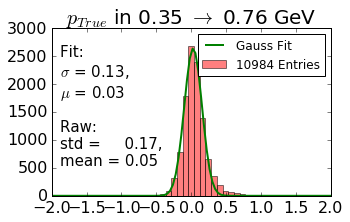

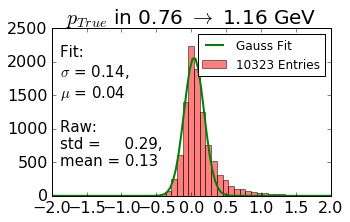

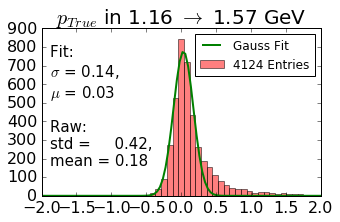

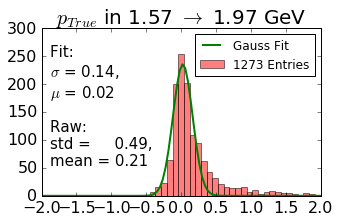

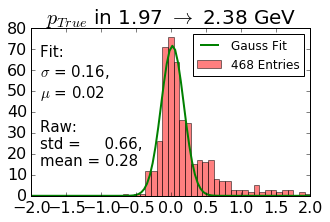

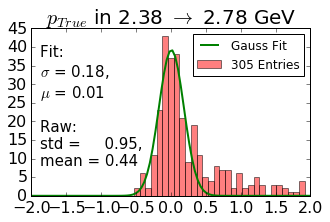

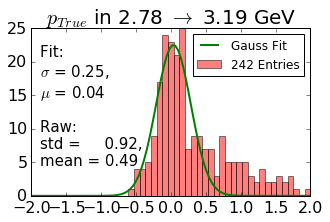

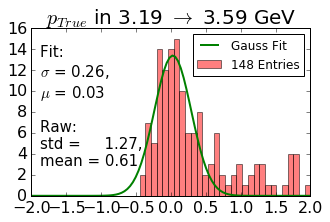

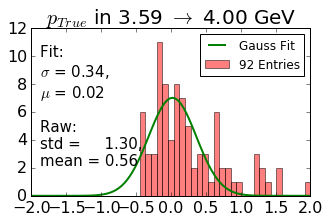

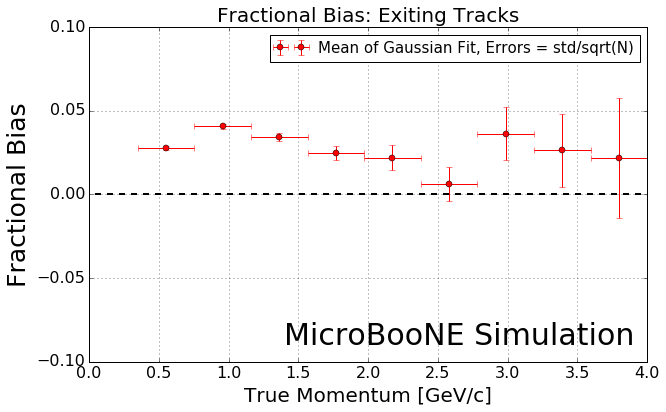

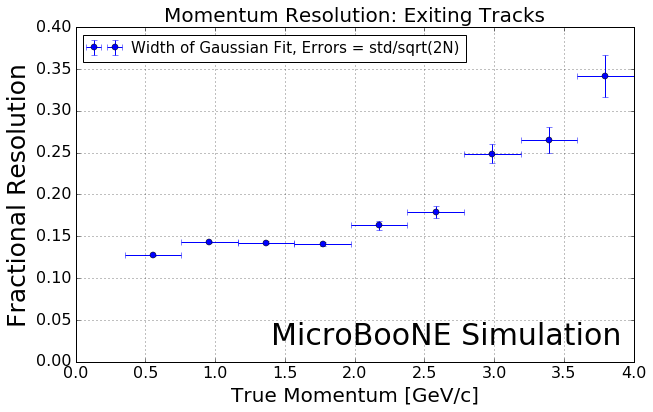

In [64]:
write_figures = False
fractional_bias_resolution_plot(xvar='true_momentum_inverse',yvar='full_MCS_momentum_inverse',xbins=np.linspace(0.35,4,10),
                       plot_bin_distributions = True,
                       slicevar = 'true_momentum',
                       slicetitlebase = 'MCS_true_exiting_resolution_%s'%anatype,
                       slicebins = np.linspace(-2,2,50),
                       biasplotname = 'MCS_true_exiting_bias_%s.png'%anatype,
                       resplotname = 'MCS_true_exiting_resolution_%s.png'%anatype,
                       biasmainfig_ylims = (-.1,.1),
                       resmainfig_ylims = (0,.40),
                       usegausfit = True,
                       extraquery = 'full_MCS_momentum < 7.4',myaddtext='MicroBooNE Simulation')

In [ ]:
mean_len_contained = np.mean( df.query('full_MCS_momentum < 7.4 and full_MCS_momentum > 0')['full_length'].values )
print mean_len_contained

In [ ]:
print len(df)
print len(df.query('full_length > 100'))

Now the scatter plot for exiting reco tracks

In [ ]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None, nbins=50, binmin = 0, binmax = 2,
                        mytitle = None):
    plt.figure(figsize=(10,6)) 
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = df.query(myquery)[xvar].values
    myy = df.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(binmin,binmax,nbins),np.linspace(binmin,binmax,nbins))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=20)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=20)
    blha = plt.title('Simulated Exiting $\\nu_\mu$CC Muon Tracks',fontsize=18)
    if mytitle is not None: blha = plt.title(mytitle,fontsize=18)

    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.05, plt.ylim()[1]*0.9, addtext, fontsize=20)
        
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"

In [ ]:
basic_comparison_fig(xvar='true_momentum',yvar='full_MCS_momentum',
                         plotname='MCS_true_comparison_%s.png'%anatype,
                        nbins=100,binmin=0,binmax=4,
                    addtext = 'MicroBooNE Simulation')